## <div align="center"> <h1 align="center"> PUPILLOMETRY BASICS </h1> </div>
## <div align="center"> <h1 align="center"> FOR LINGUISTICS </h1> </div>

## <div align="center"> <h1 align="center"> PART V: AR(1) autoregressive models </h1> </div>

## Managing autocorrelation

Autocorrelation in residuals is  a big problem in time-series data because data points are *not independent* of one another, this means that the relationship between variances changes in a systematic way, rather than being random. We often see autocorrelation plots that look like the one below, with very high lag (autocorrelation) values. Autocorrelation is especially dangerous because it inflates Type I mistakes. In order to address this problem, we must prepare prepare our data to include a *first order autoregressive structure or AR(1).* 

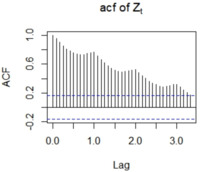

We will first load in and prep the data.

In [ ]:
list.files(path = "../input")

In [ ]:
data <- read.csv("../input/pupillometry-sample/data_pup.csv")
#sanity check
#head(data)
target_NV <- droplevels(data[(data$condition == "NVS") | (data$condition == "NVI"), ])
target_NV$participant <- as.factor(target_NV$participant)
target_NV$session <- as.factor(target_NV$session)
target_NV$condition <- as.factor(target_NV$condition)
target_NV$item <- as.factor(target_NV$item)
target_NV$regularity <- as.factor(target_NV$regularity)
#sanity check
class(target_NV$participant)
library(readr)
model1 <- readr::read_rds("../input/gamm-model1/model1.rds")
#sanity check
summary(model1)

We will now start building out AR(1) model. Remember, an AR1 model is a linear model that estimates influence of the immediately preceding measurement on the current measurement in a time-series.

Given that we need the data to be ordered thoughout time in each trial, we will need to wrangle our dataset a little bit first. Then, we will calculate rho (ρ), the autocorrelation parameter, in order to include it in the model.

In [ ]:
# We need the itsdug package to use the function start.event()
install.packages("itsadug")
library(itsadug)

# Put everything in order.
target_NV <- droplevels(target_NV[order(target_NV$bin, target_NV$participant, target_NV$session, target_NV$trial),]) 

# Mark the start event of each trial.
# target_NV <- start_event(target_NV, column = "bin", event = c("participant", "session", "trial"), order = FALSE) 
target_NV$start.event <- NULL
target_NV <- start_event(target_NV, column = "bin", event = c("participant", "session", "trial"), order = FALSE) # Mark the start event of each trial.

#target_NV$start.event <- ifelse(target_NV$bin == -25, TRUE, FALSE)

# Put everything BACK in order.
target_NV <- droplevels(target_NV[order(target_NV$participant, target_NV$session, target_NV$trial, target_NV$bin),])

# Once you have your first model without at AR1 included, you can use the function below to find the value of rho that works best for your AR1 model. This value can be tweaked +- .05
rho <- start_value_rho(model1)
print(rho)

We are are ready to create our GAMM with an AR(1) model included:

In [ ]:
model_AR1 <- bam(corrected_pupil_size ~ condition
             + s(bin, by = condition, k = 20) 
             + s(gaze_x, gaze_y) 
             + s(bin, participant, bs = 'fs', m = 1, k = 10) 
             + s(bin, item, bs = 'fs', m = 1, k = 10) 
             , family = "scat" 
             , data = target_NV 
             , method = "fREML" 
             , discrete = TRUE
             , AR.start = start.event # initialize AR(1) model
             , rho = 0.99) # value of rho rounded up to the next decimal point

summary(model_AR1)
# Note: consider this model will take at least twice as long to run than a model without an AR(1); it took my computer approximtely 15 minutes

By virtue of having included an AR(1) model, we see that the autocorrelation in our NV_AR1 model is very low!

Consider that there are other ways of improving the model fit, for example,  including a random effects structure that captures each time series. However, this method is oftentimes computationally not possible. In this ase, including an AR1 model may provide a good alternative solution

In [ ]:
acf_resid(model_AR1, split_pred = c("participant", "item"))

### In Part VI, the final part of these notebooks, we will learn how o visualize interactions between continuous variables in GAMMs.
### To be continued (one more time)!